<a href="https://colab.research.google.com/github/LEESUSUSUSU/Credit-card-fraud-detection-model/blob/main/%EC%9C%A0%EB%9F%BD%EC%B9%B4%EB%93%9C%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%AA%A8%EB%8D%B8%EB%A1%9C__%ED%95%9C%EA%B5%AD_%EC%B9%B4%EB%93%9C%EC%82%AC%EA%B8%B0_%EA%B2%80%EC%B6%9C_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
#imblearn 불균형한 데이터 셋을 맞추기 위함
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline #
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# ROC 곡선 시각화 함수 정의
def plot_roc_curves(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr):
    plt.figure(figsize=(10, 6))
    plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, log_reg_pred_prob):.3f})')
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {roc_auc_score(y_test, cnn_pred_prob):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

from sklearn.metrics import auc

def plot_roc_curves_multiple(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(10, 8))

    # 각 모델의 AUC 계산 및 플롯
    models_fpr_tpr = [
        (log_reg_fpr, log_reg_tpr, 'Logistic Regression'),
        (cnn_fpr, cnn_tpr, 'CNN'),
        (knear_fpr, knear_tpr, 'K-Nearest Neighbors'),
        (svc_fpr, svc_tpr, 'Support Vector Machine'),
        (tree_fpr, tree_tpr, 'Decision Tree')
    ]

    for fpr, tpr, label in models_fpr_tpr:
        model_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {model_auc:.2f})')

    # 기준선
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # 축과 제목 설정
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multiple Classifiers')
    plt.legend(loc='lower right')

    # 그래프 표시
    plt.show()




In [3]:
df=pd.read_csv('/content/drive/MyDrive/신용_ML/data/creditcard.csv') # 유럽
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [6]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 29, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 448)               0     

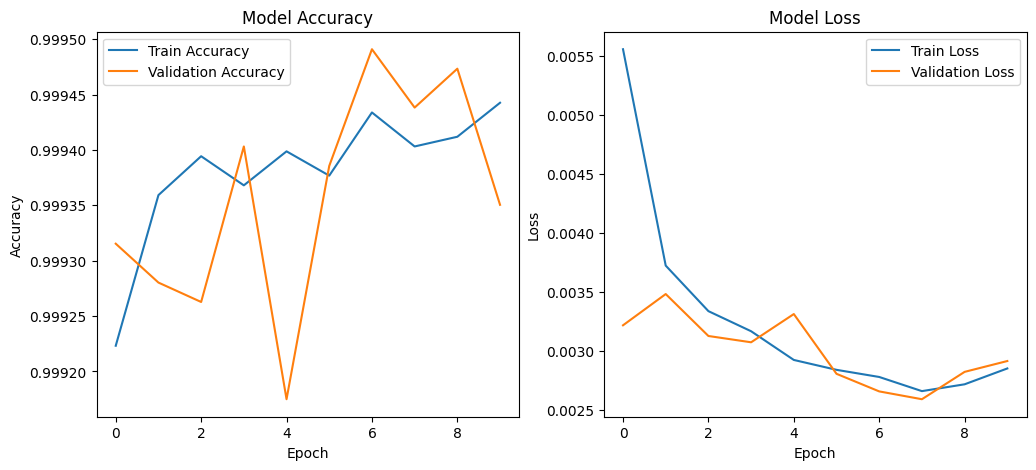

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Set seed for NumPy and TensorFlow to ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Assuming 'new_df' is your DataFrame and it's already loaded with the correct data
X = df.drop(['Class','scaled_amount'], axis=1)  # 'Class'와 'Cluster' 컬럼을 제외한 나머지를 사용
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Reshape the data for CNN input
X_train = np.expand_dims(X_train.values, axis=2)
X_test = np.expand_dims(X_test.values, axis=2)

# Define the CNN model architecture
input_shape = (X_train.shape[1], 1)  # Shape of input data
inputs = Input(shape=input_shape)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Compile the CNN model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1781/1781 [==============================] - 3s 1ms/step


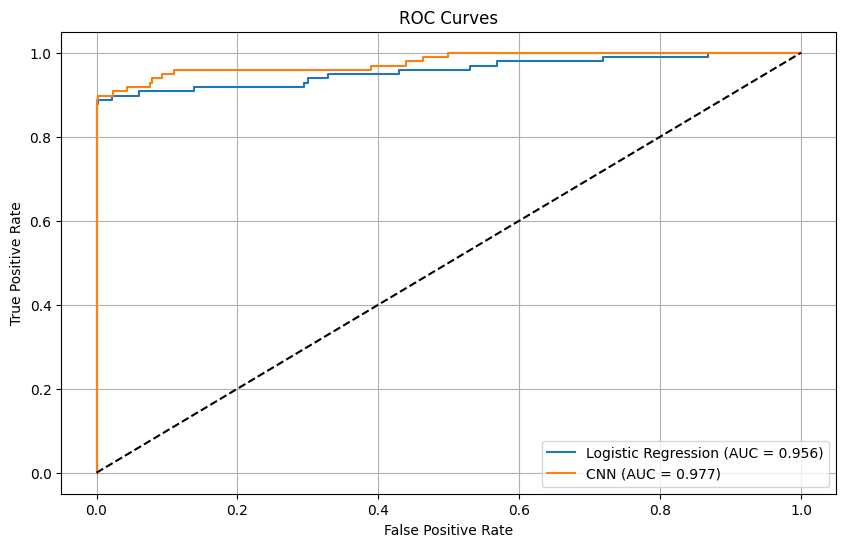

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 데이터를 2차원으로 변환
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Logistic Regression 모델 훈련 및 예측
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_2d, y_train)
log_reg_pred_prob = log_reg.predict_proba(X_test_2d)[:, 1]
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_pred_prob)

# CNN 모델의 예측 확률 계산 및 ROC 곡선 구성
cnn_pred_prob = model.predict(X_test).ravel()
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_pred_prob)



# ROC 곡선 시각화 함수 정의
def plot_roc_curves(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr):
    plt.figure(figsize=(10, 6))
    plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, log_reg_pred_prob):.3f})')
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {roc_auc_score(y_test, cnn_pred_prob):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# ROC 곡선 그리기
plot_roc_curves(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr)




In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop(['Class','scaled_amount'], axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 29, 32)            128       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 14, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 7, 64)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 448)               0   

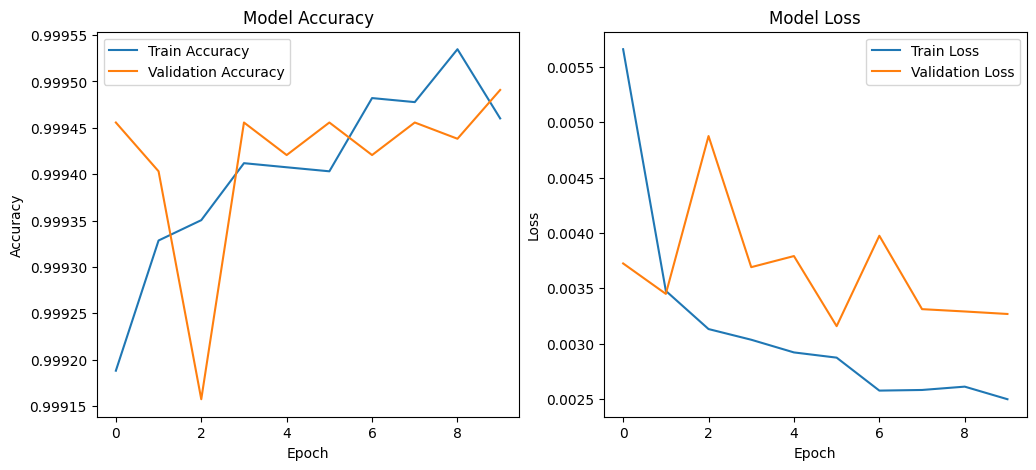

In [10]:

# Reshape the data for CNN input
original_Xtrain = np.expand_dims(original_Xtrain, axis=2)
original_Xtest = np.expand_dims(original_Xtest, axis=2)

# Define the CNN model architecture
input_shape = (original_Xtrain.shape[1], 1)  # Shape of input data
inputs = Input(shape=input_shape)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Sigmoid activation for binary classification

# Compile the CNN model
model1 = Model(inputs=inputs, outputs=output)
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model1.summary()

# Train the model
history = model1.fit(original_Xtrain, original_ytrain, epochs=10, batch_size=32, validation_data=(original_Xtest, original_ytest))

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1781/1781 [==============================] - 3s 1ms/step


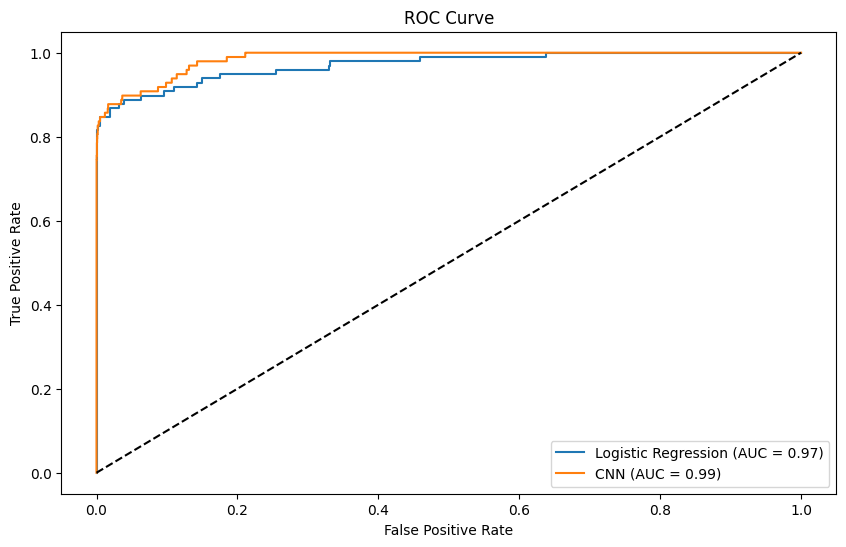

In [11]:
# 데이터를 2차원으로 변환
original_Xtrain_2d = original_Xtrain.reshape(original_Xtrain.shape[0], -1)
original_Xtest_2d = original_Xtest.reshape(original_Xtest.shape[0], -1)

# Logistic Regression 모델 훈련 및 예측
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(original_Xtrain_2d, original_ytrain)
log_reg_pred_prob = log_reg.predict_proba(original_Xtest_2d)[:, 1]
log_reg_fpr, log_reg_tpr, _ = roc_curve(original_ytest, log_reg_pred_prob)

# CNN 모델의 예측 확률 계산 및 ROC 곡선 구성
cnn_pred_prob = model1.predict(original_Xtest).ravel()
cnn_fpr, cnn_tpr, _ = roc_curve(original_ytest, cnn_pred_prob)


# AUC 계산
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)
cnn_auc = auc(cnn_fpr, cnn_tpr)

# ROC 곡선 그리기 및 AUC 표시
plt.figure(figsize=(10, 6))
plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {log_reg_auc:.2f})')
plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {cnn_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 대각선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

1781/1781 [==============================] - 3s 1ms/step


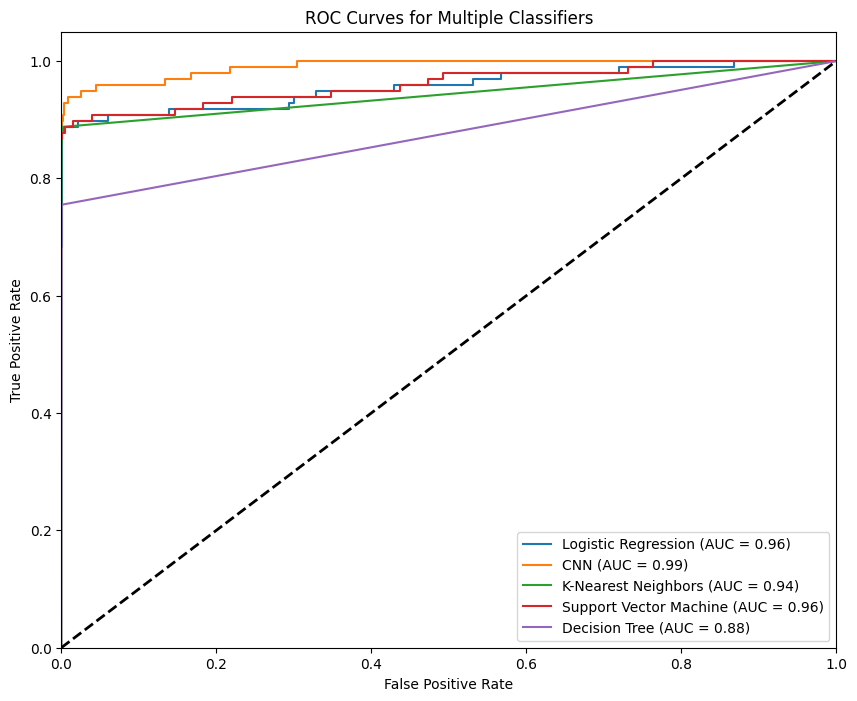

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 데이터를 2차원으로 변환
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Logistic Regression 모델 훈련 및 예측
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_2d, y_train)
log_reg_pred_prob = log_reg.predict_proba(X_test_2d)[:, 1]
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_pred_prob)

# CNN 모델의 예측 확률 계산 및 ROC 곡선 구성
cnn_pred_prob = model1.predict(X_test).ravel()
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_pred_prob)

# K-최근접 이웃 모델 훈련 및 예측
knears = KNeighborsClassifier()
knears.fit(X_train_2d, y_train)
knears_pred = knears.predict_proba(X_test_2d)[:, 1]
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_test, knears_pred)

# SVC 모델 훈련 및 예측
svc = SVC(probability=True)
svc.fit(X_train_2d, y_train)
svc_pred = svc.predict_proba(X_test_2d)[:, 1]
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred)

# 결정 트리 모델 훈련 및 예측
tree = DecisionTreeClassifier()
tree.fit(X_train_2d, y_train)
tree_pred = tree.predict_proba(X_test_2d)[:, 1]
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, tree_pred)

# ROC 곡선 시각화
plot_roc_curves_multiple(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)


In [13]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# 각 분류기에 대한 예측
log_reg_pred = log_reg.predict(X_test_2d)
knears_pred = knears.predict(X_test_2d)
svc_pred = svc.predict(X_test_2d)
tree_pred = tree.predict(X_test_2d)

# 모델 성능 평가 및 출력
models = [('Logistic Regression', log_reg_pred), ('K-Nearest Neighbors', knears_pred),
          ('SVC', svc_pred), ('Decision Tree', tree_pred)]
for model_name, y_pred in models:
    print('---' * 25)
    print(f'{model_name} - Test Set Evaluation:\n')
    print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('---' * 25)

# 샘플 데이터의 평균 성능 지표 (여기서는 임의의 값으로 설정, 실제 데이터에 맞게 조정 필요)
undersample_accuracy = [0.95]  # 예시 값
undersample_precision = [0.97]
undersample_recall = [0.93]
undersample_f1 = [0.95]

print('---' * 25)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 25)


---------------------------------------------------------------------------
Logistic Regression - Test Set Evaluation:

Recall Score: 0.65
Precision Score: 0.83
F1 Score: 0.73
Accuracy Score: 1.00
---------------------------------------------------------------------------
---------------------------------------------------------------------------
K-Nearest Neighbors - Test Set Evaluation:

Recall Score: 0.81
Precision Score: 0.91
F1 Score: 0.85
Accuracy Score: 1.00
---------------------------------------------------------------------------
---------------------------------------------------------------------------
SVC - Test Set Evaluation:

Recall Score: 0.69
Precision Score: 0.94
F1 Score: 0.80
Accuracy Score: 1.00
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Decision Tree - Test Set Evaluation:

Recall Score: 0.76
Precision Score: 0.70
F1 Score: 0.73
Accuracy Score: 1.00
------

In [14]:
df1=pd.read_csv('/content/drive/MyDrive/신용_ML/data/한국 카드 사기/val.csv') # 한국

In [15]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler


rob_scaler = RobustScaler()

df1['scaled_ID'] = rob_scaler.fit_transform(df1['ID'].values.reshape(-1,1))

df1.drop(['ID'], axis=1, inplace=True)

In [16]:

scaled_time = df1['ID']

df1.drop(['ID'], axis=1, inplace=True)

df1.insert(1, 'ID', scaled_time)
# Amount and Time are Scaled!

df1.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df1.drop(['Class'], axis=1)
y = df1['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


8901/8901 [==============================] - 13s 2ms/step


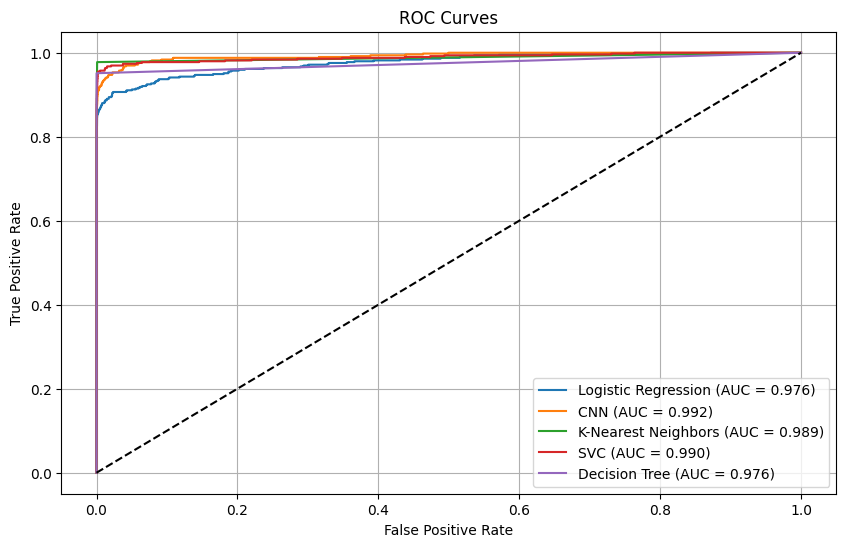

In [18]:
# 데이터 전처리
X = df1.drop(['Class'], axis=1)  # 'Class'와 'Cluster' 컬럼을 제외한 나머지를 사용
y = df1['Class']

# 데이터를 2차원으로 변환
X_2d = X.values.reshape(X.shape[0], -1)

# Logistic Regression 예측 및 ROC 곡선 계산
log_reg_pred_prob = log_reg.predict_proba(X_2d)[:, 1]
log_reg_fpr, log_reg_tpr, _ = roc_curve(y, log_reg_pred_prob)

# CNN 모델 예측 및 ROC 곡선 계산
X_3d = np.expand_dims(X.values, axis=2)
cnn_pred_prob = model.predict(X_3d).ravel()
cnn_fpr, cnn_tpr, _ = roc_curve(y, cnn_pred_prob)

# K-최근접 이웃 예측 및 ROC 곡선 계산
knears_pred_prob = knears.predict_proba(X_2d)[:, 1]
knear_fpr, knear_tpr, _ = roc_curve(y, knears_pred_prob)

# SVC 예측 및 ROC 곡선 계산
svc_pred_prob = svc.predict_proba(X_2d)[:, 1]
svc_fpr, svc_tpr, _ = roc_curve(y, svc_pred_prob)

# 결정 트리 예측 및 ROC 곡선 계산
tree_pred_prob = tree.predict_proba(X_2d)[:, 1]
tree_fpr, tree_tpr, _ = roc_curve(y, tree_pred_prob)

# ROC 곡선 시각화 함수 정의
def plot_roc_curves_multiple(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(10, 6))
    plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y, log_reg_pred_prob):.3f})')
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {roc_auc_score(y, cnn_pred_prob):.3f})')
    plt.plot(knear_fpr, knear_tpr, label=f'K-Nearest Neighbors (AUC = {roc_auc_score(y, knears_pred_prob):.3f})')
    plt.plot(svc_fpr, svc_tpr, label=f'SVC (AUC = {roc_auc_score(y, svc_pred_prob):.3f})')
    plt.plot(tree_fpr, tree_tpr, label=f'Decision Tree (AUC = {roc_auc_score(y, tree_pred_prob):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# ROC 곡선 시각화
plot_roc_curves_multiple(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)

8901/8901 [==============================] - 13s 2ms/step


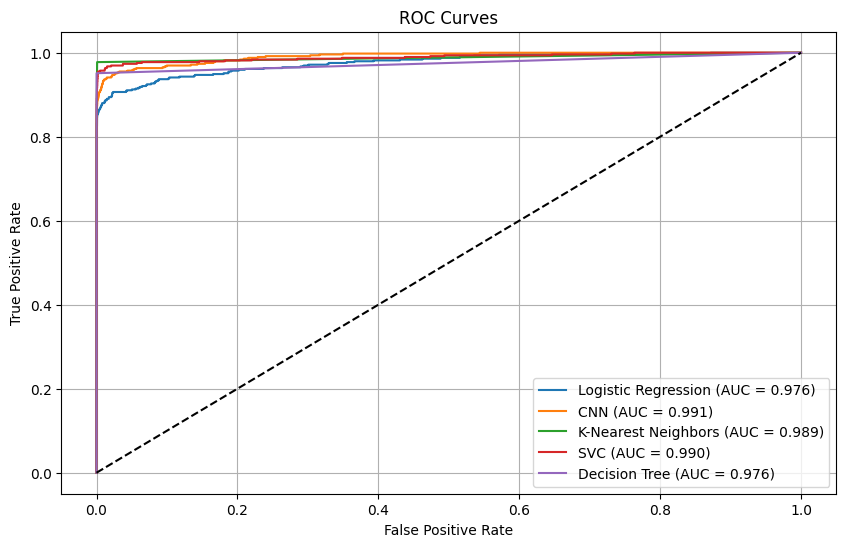

In [19]:
# 데이터 전처리
X = df1.drop(['Class'], axis=1)  # 'Class'와 'Cluster' 컬럼을 제외한 나머지를 사용
y = df1['Class']

# 데이터를 2차원으로 변환
X_2d = X.values.reshape(X.shape[0], -1)

# Logistic Regression 예측 및 ROC 곡선 계산
log_reg_pred_prob = log_reg.predict_proba(X_2d)[:, 1]
log_reg_fpr, log_reg_tpr, _ = roc_curve(y, log_reg_pred_prob)

# CNN 모델 예측 및 ROC 곡선 계산
X_3d = np.expand_dims(X.values, axis=2)
cnn_pred_prob = model1.predict(X_3d).ravel()
cnn_fpr, cnn_tpr, _ = roc_curve(y, cnn_pred_prob)

# K-최근접 이웃 예측 및 ROC 곡선 계산
knears_pred_prob = knears.predict_proba(X_2d)[:, 1]
knear_fpr, knear_tpr, _ = roc_curve(y, knears_pred_prob)

# SVC 예측 및 ROC 곡선 계산
svc_pred_prob = svc.predict_proba(X_2d)[:, 1]
svc_fpr, svc_tpr, _ = roc_curve(y, svc_pred_prob)

# 결정 트리 예측 및 ROC 곡선 계산
tree_pred_prob = tree.predict_proba(X_2d)[:, 1]
tree_fpr, tree_tpr, _ = roc_curve(y, tree_pred_prob)

# ROC 곡선 시각화 함수 정의
def plot_roc_curves_multiple(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(10, 6))
    plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y, log_reg_pred_prob):.3f})')
    plt.plot(cnn_fpr, cnn_tpr, label=f'CNN (AUC = {roc_auc_score(y, cnn_pred_prob):.3f})')
    plt.plot(knear_fpr, knear_tpr, label=f'K-Nearest Neighbors (AUC = {roc_auc_score(y, knears_pred_prob):.3f})')
    plt.plot(svc_fpr, svc_tpr, label=f'SVC (AUC = {roc_auc_score(y, svc_pred_prob):.3f})')
    plt.plot(tree_fpr, tree_tpr, label=f'Decision Tree (AUC = {roc_auc_score(y, tree_pred_prob):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# ROC 곡선 시각화
plot_roc_curves_multiple(log_reg_fpr, log_reg_tpr, cnn_fpr, cnn_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)